In [1]:
%matplotlib inline
import pystan as ps
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.special import logit, expit
import re
import os
import pymc3 as pm
from theano import tensor as tt

# Generate Data 

Blue line is true distribution, points are data.

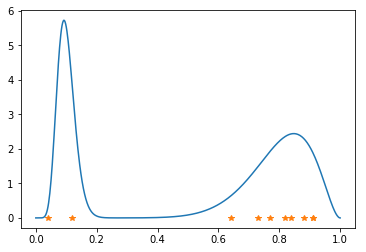

In [10]:
mu0 = np.array([0.8, 0.1])
t0 = np.array([0.4, 0.1])
p0 = np.array([0.6, 0.4])

a = 1/(t0-t0*mu0)-mu0
b = 1/(t0*mu0)-1+mu0

Nbin = 100
Nsamp = 10

Nsubsamp = np.random.multinomial(Nsamp, p0)
datavals = np.array([], dtype=int)
for idx, Nss in enumerate(Nsubsamp):
    pvals = np.random.beta(a[idx],b[idx],Nss)
    datavals = np.concatenate([datavals, np.random.binomial(Nbin,pvals)])
    
data1 = dict(Nsamp=Nsamp, Nbin=Nbin, Nc=15, x=datavals, mu=np.dot(mu0,p0))

def weighted_beta(weights, mu, t):
    x = np.linspace(0,1,500)
    y = np.zeros(len(x))
    for idx in range(len(weights)):
        a = 1/(t[idx]-t[idx]*mu[idx])-mu[idx]
        b = 1/(t[idx]*mu[idx])-1+mu[idx]
        y += weights[idx] * st.beta.pdf(x, a, b)
    return x, y

x,y = weighted_beta(p0, mu0, t0)
plt.plot(x,y)
plt.plot(datavals / float(Nbin), np.zeros(Nsamp),'*');

# PyMC3 Model 

In [11]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining
def scale_nu(weights, locations, mu0):
    n = weights.shape[0]
    exp_locations = tt.exp(-locations)
    
    h = pm.math.logit(mu0) - tt.dot(weights, locations)
    for i in range(2):
        tmp = pm.math.invlogit(h + locations)
        h = h - (tt.dot(weights, tmp) - mu0) / (tt.dot(weights, tmp * (1-tmp)))
        # print(h.tag.test_value)
    return pm.math.invlogit(h + locations)

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1, 1)
    q = pm.Beta('q', 1, alpha, shape=data1['Nc'])
    w = pm.Deterministic('w', stick_breaking(q))
    
    nu_star = pm.Normal('nu_star', 0, 1.9, shape=data1['Nc'], testval=np.ones((data1['Nc'])))
    t = pm.Beta('t', 1, 1, shape=data1['Nc'])
    nu = pm.Deterministic('nu', scale_nu(w, nu_star, data1['mu']))
    a_ = 1/(t * (1-nu)) - nu
    # print(a_.tag.test_value)
    obs = pm.Mixture('obs', w,
                    pm.BetaBinomial.dist(
                                        alpha = 1/(t * (1-nu)) - nu,
                                        beta = 1/(t * nu) - (1-nu),
                                        n = data1['Nbin']
                                        ),
                    observed=data1['x']
                    )

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using ADVI...
Average Loss = 613.11: 100%|██████████| 200000/200000 [01:13<00:00, 2719.40it/s]
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 613.09
100%|██████████| 3000/3000 [01:00<00:00, 62.55it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 0 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 1 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)


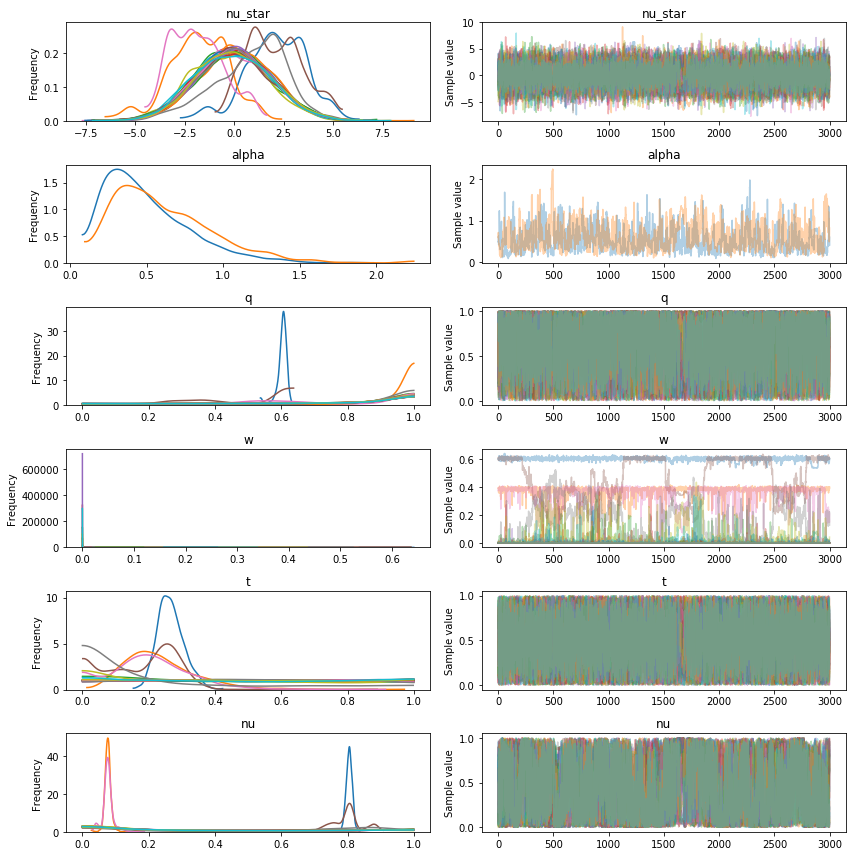

In [12]:
with model:
    trace = pm.sample(3000, njobs=2, tune=1000)

pm.traceplot(trace);

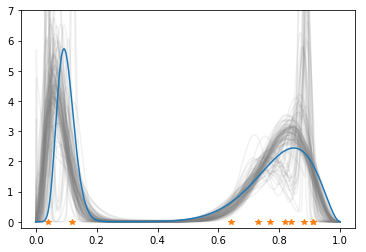

In [15]:
randlist = np.random.choice(1000, 100, replace=False)
burnin=2000
for i in np.sort(randlist):
    point = trace[burnin+i]
    x,y = weighted_beta(weights=point['w'], mu=point['nu'], t=point['t'])
    plt.plot(x, y, color='grey', alpha=.1)
    
x,y = weighted_beta(p0, mu0, t0)
plt.plot(x,y)
plt.plot(datavals / float(Nbin), np.zeros(Nsamp), '*')
plt.ylim(-.2,7);